## Import the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Import the Data

In [2]:
data = pd.read_csv('denver_crime_8-26-2019.csv')
data2 = pd.read_csv('denver_offense_codes.csv')

### Preview the Data

In [3]:
data.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,NaN,6/15/2016 11:31:00 PM,NaN,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,0
1,20186000994,20186000994239900,2399,0,theft-other,larceny,10/11/2017 12:30:00 PM,10/11/2017 4:55:00 PM,1/29/2018 5:53:00 PM,NaN,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,4/25/2016 8:00:00 AM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0
3,201872333,201872333239900,2399,0,theft-other,larceny,1/30/2018 7:20:00 PM,NaN,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,6/22/2017 8:53:00 PM,NaN,6/23/2017 4:09:00 PM,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0


In [4]:
data2.head()

,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_ID,OFFENSE_CATEGORY_NAME,IS_CRIME,IS_TRAFFIC
0,2804,1,stolen-property-possession,Possession of stolen property,all-other-crimes,All Other Crimes,1,0
1,2804,2,fraud-possess-financial-device,Possession of a financial device,all-other-crimes,All Other Crimes,1,0
2,2901,0,damaged-prop-bus,Damaged business property,public-disorder,Public Disorder,1,0
3,2902,0,criminal-mischief-private,Criminal mischief to private property,public-disorder,Public Disorder,1,0
4,2903,0,criminal-mischief-public,Criminal mischief to public property,public-disorder,Public Disorder,1,0


## Modify `data` DataFrame
There are a few things we want to do here:
1. Remove all non-crime occurances (non-criminal traffic violations)
2. Convert `FIRST_OCCURRENCE_DATE` to pandas datetime data type
         - remove all occurances 30 days prior to 8-26-2019 (the data source states that it generally takes 30 days for the data to be considered accurate)
3. Append columns `YEAR`, `MONTH`, `DAY`, `DAY_OF_WEEK`, `DAY_OF_YEAR`, and `HOUR` to our DataFrame so we can easily sort when an incident occured by various features
4. Convert `REPORTED_DATE` to pandas datetime data type
5. Add a column `DIFF_DAYS` which will indicate the difference in days from when the offense occurred and when it was reported (could be interesting to see if certain crimes take longer to report than others)

### 1. Remove all non-crime occurances

In [5]:
data.shape

(507443, 19)

In [6]:
crime = data[data.IS_CRIME == 1]

In [7]:
crime.shape

(375532, 19)

In [8]:
len(data) - len(crime)

131911

Looks like we removed `131,911` non-criminal offenses from our dataset. Now that our DataFrame is smaller (and the to_datetime function takes awhile on my computer), we should make the `FIRST_OCCURRENCE_DATE` conversion to datetime datatype.

### 2. Convert `FIRST_OCCURRENCE_DATE` to pandas datetime data type

In [9]:
new_crime = crime.astype({'FIRST_OCCURRENCE_DATE': 'datetime64'})

In [10]:
new_crime.dtypes

INCIDENT_ID                        int64
OFFENSE_ID                         int64
OFFENSE_CODE                       int64
OFFENSE_CODE_EXTENSION             int64
OFFENSE_TYPE_ID                   object
OFFENSE_CATEGORY_ID               object
FIRST_OCCURRENCE_DATE     datetime64[ns]
LAST_OCCURRENCE_DATE              object
REPORTED_DATE                     object
INCIDENT_ADDRESS                  object
GEO_X                            float64
GEO_Y                            float64
GEO_LON                          float64
GEO_LAT                          float64
DISTRICT_ID                        int64
PRECINCT_ID                        int64
NEIGHBORHOOD_ID                   object
IS_CRIME                           int64
IS_TRAFFIC                         int64
dtype: object

Our new DataFrame, `new_crime`, now has the entire `FIRST_OCCURRENCE_DATE` column as a datetime64 type, so we can eliminate all crimes 30 days prior to August 26, 2018.

In [11]:
latest_date = pd.to_datetime('August 26, 2019') #this is when the data was last updated

In [12]:
update_date = latest_date - pd.Timedelta(30, unit='D')

In [13]:
update_date

Timestamp('2019-07-27 00:00:00')

Now we have our latest accurate crime date. So we can eliminate all crime occurring after this date.

In [14]:
acc_crime = new_crime[(new_crime.FIRST_OCCURRENCE_DATE < update_date)]

In [15]:
len(new_crime) - len(acc_crime)

5058

Looks like we have removed 5,058 crime occurrences that occurred between July 27, 2019 and August 26, 2019. We can double check this by finding the latest date in our `FIRST_OCCURRENCE_DATE` column.

In [16]:
acc_crime.FIRST_OCCURRENCE_DATE.max()

Timestamp('2019-07-26 23:44:00')

Looks good, the latest date in our `FIRST_OCCURRENCE_DATE` column turns out to be July 26, 2019 at 11:44 PM.

### 3. Append columns `YEAR`, `MONTH`, `DAY`, `DAY_OF_WEEK`, `DAY_OF_YEAR`, and `HOUR` to our DataFrame so we can easily sort when an incident occured by various features

In [17]:
acc_crime['YEAR'] = acc_crime.FIRST_OCCURRENCE_DATE.dt.year
acc_crime['MONTH'] = acc_crime.FIRST_OCCURRENCE_DATE.dt.month
acc_crime['DAY'] = acc_crime.FIRST_OCCURRENCE_DATE.dt.day
acc_crime['DAY_OF_WEEK'] = acc_crime.FIRST_OCCURRENCE_DATE.dt.dayofweek
acc_crime['DAY_OF_YEAR'] = acc_crime.FIRST_OCCURRENCE_DATE.dt.dayofyear
acc_crime['HOUR'] = acc_crime.FIRST_OCCURRENCE_DATE.dt.hour
#how do I avoid SettingWithCopyWarning???

c:\users\philb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\philb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\philb\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [18]:
acc_crime.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,...,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,YEAR,MONTH,DAY,DAY_OF_WEEK,DAY_OF_YEAR,HOUR
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,2016-06-15 23:31:00,NaN,6/15/2016 11:31:00 PM,NaN,...,521,montbello,1,0,2016,6,15,2,167,23
1,20186000994,20186000994239900,2399,0,theft-other,larceny,2017-10-11 12:30:00,10/11/2017 4:55:00 PM,1/29/2018 5:53:00 PM,NaN,...,522,gateway-green-valley-ranch,1,0,2017,10,11,2,284,12
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,2016-03-04 20:00:00,4/25/2016 8:00:00 AM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,...,314,wellshire,1,0,2016,3,4,4,64,20
3,201872333,201872333239900,2399,0,theft-other,larceny,2018-01-30 19:20:00,NaN,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,...,312,belcaro,1,0,2018,1,30,1,30,19
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,2017-06-22 20:53:00,NaN,6/23/2017 4:09:00 PM,2810 E 1ST AVE,...,311,cherry-creek,1,0,2017,6,22,3,173,20


In [19]:
acc_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370474 entries, 0 to 507442
Data columns (total 25 columns):
INCIDENT_ID               370474 non-null int64
OFFENSE_ID                370474 non-null int64
OFFENSE_CODE              370474 non-null int64
OFFENSE_CODE_EXTENSION    370474 non-null int64
OFFENSE_TYPE_ID           370474 non-null object
OFFENSE_CATEGORY_ID       370474 non-null object
FIRST_OCCURRENCE_DATE     370474 non-null datetime64[ns]
LAST_OCCURRENCE_DATE      158169 non-null object
REPORTED_DATE             370474 non-null object
INCIDENT_ADDRESS          336860 non-null object
GEO_X                     366343 non-null float64
GEO_Y                     366343 non-null float64
GEO_LON                   366343 non-null float64
GEO_LAT                   366343 non-null float64
DISTRICT_ID               370474 non-null int64
PRECINCT_ID               370474 non-null int64
NEIGHBORHOOD_ID           370474 non-null object
IS_CRIME                  370474 non-null int64
IS

### 4. Convert `REPORTED_DATE` to pandas datetime data type

In [20]:
rep_crime = acc_crime.astype({'REPORTED_DATE': 'datetime64'})

In [21]:
rep_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370474 entries, 0 to 507442
Data columns (total 25 columns):
INCIDENT_ID               370474 non-null int64
OFFENSE_ID                370474 non-null int64
OFFENSE_CODE              370474 non-null int64
OFFENSE_CODE_EXTENSION    370474 non-null int64
OFFENSE_TYPE_ID           370474 non-null object
OFFENSE_CATEGORY_ID       370474 non-null object
FIRST_OCCURRENCE_DATE     370474 non-null datetime64[ns]
LAST_OCCURRENCE_DATE      158169 non-null object
REPORTED_DATE             370474 non-null datetime64[ns]
INCIDENT_ADDRESS          336860 non-null object
GEO_X                     366343 non-null float64
GEO_Y                     366343 non-null float64
GEO_LON                   366343 non-null float64
GEO_LAT                   366343 non-null float64
DISTRICT_ID               370474 non-null int64
PRECINCT_ID               370474 non-null int64
NEIGHBORHOOD_ID           370474 non-null object
IS_CRIME                  370474 non-null 

Looks good. Now we can find the difference in days between our reported date and first occurance date, to see if certain crimes may have a greater length of time between when they are committed and reported.

### 5. Add a column `DIFF_DAYS` which will indicate the difference in days from when the offense occurred and when it was reported 

In [22]:
rep_crime['DIFF_DAYS'] = (rep_crime['REPORTED_DATE'] - rep_crime['FIRST_OCCURRENCE_DATE']).dt.days

In [23]:
rep_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370474 entries, 0 to 507442
Data columns (total 26 columns):
INCIDENT_ID               370474 non-null int64
OFFENSE_ID                370474 non-null int64
OFFENSE_CODE              370474 non-null int64
OFFENSE_CODE_EXTENSION    370474 non-null int64
OFFENSE_TYPE_ID           370474 non-null object
OFFENSE_CATEGORY_ID       370474 non-null object
FIRST_OCCURRENCE_DATE     370474 non-null datetime64[ns]
LAST_OCCURRENCE_DATE      158169 non-null object
REPORTED_DATE             370474 non-null datetime64[ns]
INCIDENT_ADDRESS          336860 non-null object
GEO_X                     366343 non-null float64
GEO_Y                     366343 non-null float64
GEO_LON                   366343 non-null float64
GEO_LAT                   366343 non-null float64
DISTRICT_ID               370474 non-null int64
PRECINCT_ID               370474 non-null int64
NEIGHBORHOOD_ID           370474 non-null object
IS_CRIME                  370474 non-null 

So we finally have a DataFrame called `rep_crime` with a lot of useful stuff we can look into. Before we do that, we can merge our `data2` DataFrame with our `rep_crime` DataFrame.

## Merge `rep_crime` with `data2`

In [24]:
rep_crime.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,...,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,YEAR,MONTH,DAY,DAY_OF_WEEK,DAY_OF_YEAR,HOUR,DIFF_DAYS
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,2016-06-15 23:31:00,NaN,2016-06-15 23:31:00,NaN,...,montbello,1,0,2016,6,15,2,167,23,0
1,20186000994,20186000994239900,2399,0,theft-other,larceny,2017-10-11 12:30:00,10/11/2017 4:55:00 PM,2018-01-29 17:53:00,NaN,...,gateway-green-valley-ranch,1,0,2017,10,11,2,284,12,110
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,2016-03-04 20:00:00,4/25/2016 8:00:00 AM,2016-04-26 21:02:00,2932 S JOSEPHINE ST,...,wellshire,1,0,2016,3,4,4,64,20,53
3,201872333,201872333239900,2399,0,theft-other,larceny,2018-01-30 19:20:00,NaN,2018-01-30 22:29:00,705 S COLORADO BLVD,...,belcaro,1,0,2018,1,30,1,30,19,0
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,2017-06-22 20:53:00,NaN,2017-06-23 16:09:00,2810 E 1ST AVE,...,cherry-creek,1,0,2017,6,22,3,173,20,0


In [25]:
data2.head()

,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_TYPE_NAME,OFFENSE_CATEGORY_ID,OFFENSE_CATEGORY_NAME,IS_CRIME,IS_TRAFFIC
0,2804,1,stolen-property-possession,Possession of stolen property,all-other-crimes,All Other Crimes,1,0
1,2804,2,fraud-possess-financial-device,Possession of a financial device,all-other-crimes,All Other Crimes,1,0
2,2901,0,damaged-prop-bus,Damaged business property,public-disorder,Public Disorder,1,0
3,2902,0,criminal-mischief-private,Criminal mischief to private property,public-disorder,Public Disorder,1,0
4,2903,0,criminal-mischief-public,Criminal mischief to public property,public-disorder,Public Disorder,1,0


In [26]:
den_crime = rep_crime.merge(data2)

In [27]:
den_crime.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370474 entries, 0 to 370473
Data columns (total 28 columns):
INCIDENT_ID               370474 non-null int64
OFFENSE_ID                370474 non-null int64
OFFENSE_CODE              370474 non-null int64
OFFENSE_CODE_EXTENSION    370474 non-null int64
OFFENSE_TYPE_ID           370474 non-null object
OFFENSE_CATEGORY_ID       370474 non-null object
FIRST_OCCURRENCE_DATE     370474 non-null datetime64[ns]
LAST_OCCURRENCE_DATE      158169 non-null object
REPORTED_DATE             370474 non-null datetime64[ns]
INCIDENT_ADDRESS          336860 non-null object
GEO_X                     366343 non-null float64
GEO_Y                     366343 non-null float64
GEO_LON                   366343 non-null float64
GEO_LAT                   366343 non-null float64
DISTRICT_ID               370474 non-null int64
PRECINCT_ID               370474 non-null int64
NEIGHBORHOOD_ID           370474 non-null object
IS_CRIME                  370474 non-null 

We can make another DataFrame with only the columns we are interested in. This resulting DataFrame will be the final version where we will conduct an exploratory analysis. 

In [28]:
fin_crime = den_crime[['OFFENSE_TYPE_ID',
 'OFFENSE_TYPE_NAME',   
 'OFFENSE_CATEGORY_ID',
 'OFFENSE_CATEGORY_NAME',
 'FIRST_OCCURRENCE_DATE',
 'YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'DAY_OF_YEAR',
 'HOUR',
 'LAST_OCCURRENCE_DATE',
 'REPORTED_DATE',
 'DIFF_DAYS',
 'DISTRICT_ID',
 'PRECINCT_ID',
 'NEIGHBORHOOD_ID']]

In [35]:
fin_crime.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370474 entries, 0 to 370473
Data columns (total 17 columns):
OFFENSE_TYPE_ID          370474 non-null object
OFFENSE_TYPE_NAME        370474 non-null object
OFFENSE_CATEGORY_ID      370474 non-null object
OFFENSE_CATEGORY_NAME    370474 non-null object
FIRST_OCCURRENCE_DATE    370474 non-null datetime64[ns]
YEAR                     370474 non-null int64
MONTH                    370474 non-null int64
DAY                      370474 non-null int64
DAY_OF_WEEK              370474 non-null int64
DAY_OF_YEAR              370474 non-null int64
HOUR                     370474 non-null int64
LAST_OCCURRENCE_DATE     158169 non-null object
REPORTED_DATE            370474 non-null datetime64[ns]
DIFF_DAYS                370474 non-null int64
DISTRICT_ID              370474 non-null int64
PRECINCT_ID              370474 non-null int64
NEIGHBORHOOD_ID          370474 non-null object
dtypes: datetime64[ns](2), int64(9), object(6)
memory usage: 127.9

One more tweak before the exploratory analysis. We should probably remove the `LAST_OCCURRENCE_DATE` column as it has a majority of rows with null data.

In [45]:
fin_crime.drop('LAST_OCCURRENCE_DATE', axis=1, inplace=True)

c:\users\philb\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [46]:
fin_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370474 entries, 0 to 370473
Data columns (total 16 columns):
OFFENSE_TYPE_ID          370474 non-null object
OFFENSE_TYPE_NAME        370474 non-null object
OFFENSE_CATEGORY_ID      370474 non-null object
OFFENSE_CATEGORY_NAME    370474 non-null object
FIRST_OCCURRENCE_DATE    370474 non-null datetime64[ns]
YEAR                     370474 non-null int64
MONTH                    370474 non-null int64
DAY                      370474 non-null int64
DAY_OF_WEEK              370474 non-null int64
DAY_OF_YEAR              370474 non-null int64
HOUR                     370474 non-null int64
REPORTED_DATE            370474 non-null datetime64[ns]
DIFF_DAYS                370474 non-null int64
DISTRICT_ID              370474 non-null int64
PRECINCT_ID              370474 non-null int64
NEIGHBORHOOD_ID          370474 non-null object
dtypes: datetime64[ns](2), int64(9), object(5)
memory usage: 41.0+ MB


Looks like we have a DataFrame with only criminal occurrences set up in a useful way.

## Exploratory Data Analysis on `fin_crime`

A few simple value counts may be worth asking here to get us started. Let's check out the most common crimes by `OFFENSE_CATEGORY_NAME` and `OFFENSE_TYPE_NAME` as these are the greatest descriptors for the type of crime committed.                 

In [50]:
fin_crime.OFFENSE_CATEGORY_NAME.value_counts()

All Other Crimes                90911
Public Disorder                 52162
Larceny                         50727
Theft from Motor Vehicle        37725
Drug & Alcohol                  33016
Auto Theft                      26677
Burglary                        24655
Other Crimes Against Persons    24564
Aggravated Assault              11738
White Collar Crime               6790
Robbery                          6457
Sexual Assault                   4134
Arson                             627
Murder                            291
Name: OFFENSE_CATEGORY_NAME, dtype: int64

In [51]:
len(fin_crime.OFFENSE_CATEGORY_NAME.value_counts())

14

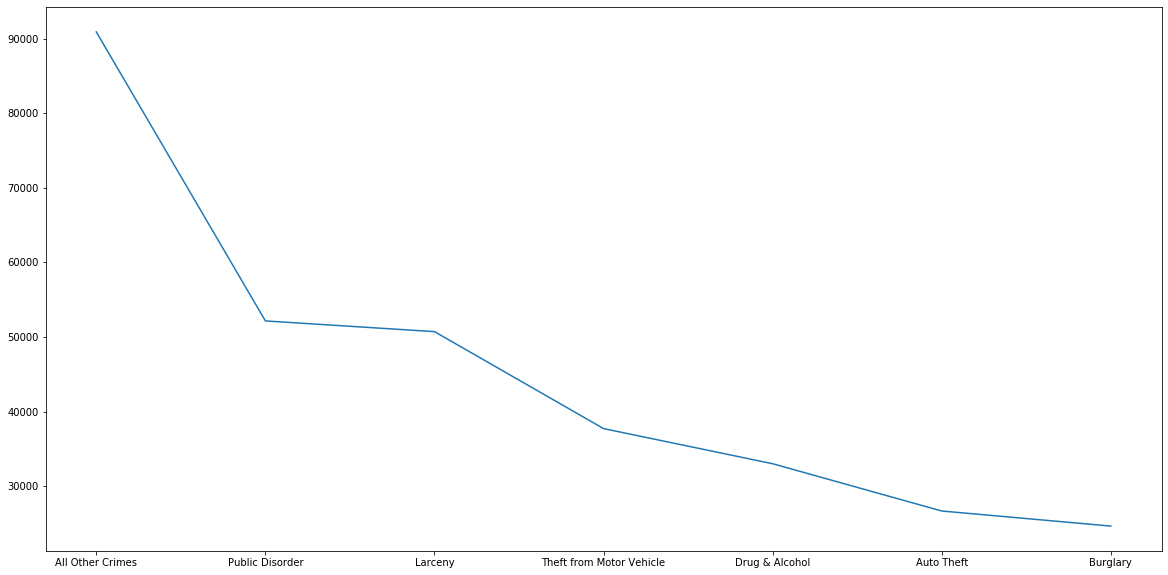

In [66]:
plt.figure(figsize=(20, 10))
plt.plot(fin_crime.OFFENSE_CATEGORY_NAME.value_counts().nlargest(7))
plt.show()

From the above we can see we have 14 distinct categories in the `OFFENSE_CATEGORY_NAME` column. The one that occurs most is 'All Other Crimes' which isn't very descriptive - we may need to eliminate that category from our DataFrame as we pare things down. Let's check the `OFFENSE_TYPE_NAME` now.

In [62]:
fin_crime.OFFENSE_TYPE_NAME.value_counts()

Traffic offense - other          32810
Theft of items from a vehicle    26942
Motor vehicle theft              26105
Theft - other                    20264
Criminal trespassing             15529
                                 ...  
Theft of cable services              1
Inciting a riot                      1
Possession of an explosive           1
Theft from a yard                    1
Engaging in  a riot                  1
Name: OFFENSE_TYPE_NAME, Length: 196, dtype: int64

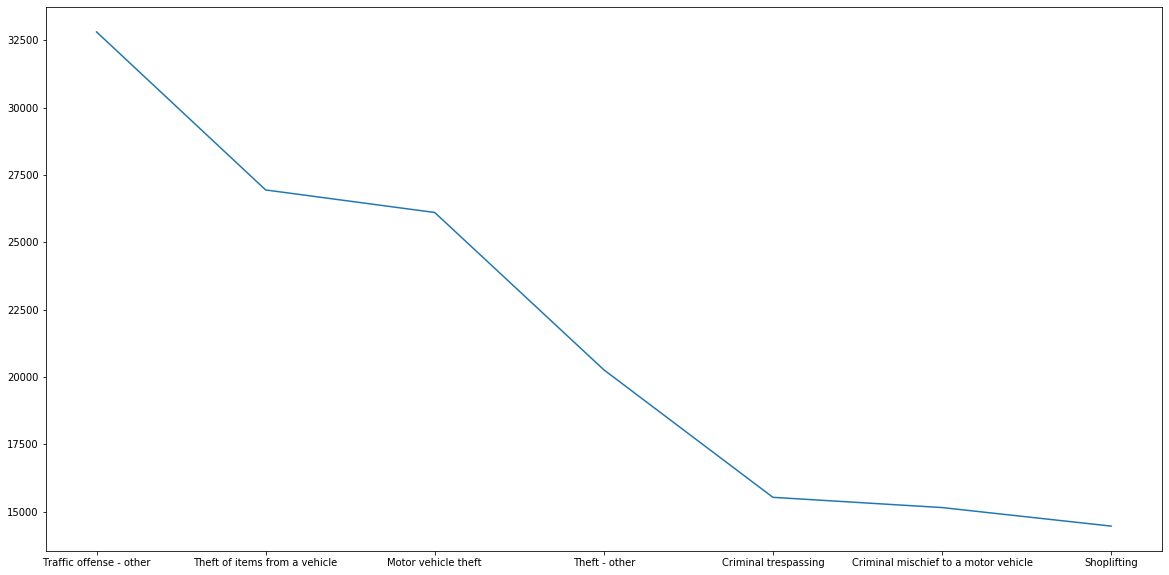

In [67]:
plt.figure(figsize=(20, 10))
plt.plot(fin_crime.OFFENSE_TYPE_NAME.value_counts().nlargest(7))
plt.show()

From the above we can see that this may be a little more descriptive of our data, however this is a long series of values and is more difficult to separate into categories. It may be useful to eliminate certain traffic offenses down the line as this seems to be the most prominent type of crime.